In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("TaxiDemandAnalysis_FullLoad") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

base_path = "/content/drive/MyDrive/Mining of massive dataset/data"

years = [str(year) for year in range(2011,2012)]
paths = [os.path.join(base_path, year) for year in years]

df = spark.read.parquet(*paths)


In [25]:
print("Schema")
df.printSchema()

print("Total Rows")
print(df.count())

Schema
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

Total Rows
190352256


In [19]:
from pyspark.sql.functions import *
df.repartition(6)

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

### Trực quan hóa và phân tích dữ liệu năm 2024 trong dữ liệu

In [35]:
print(df.show(truncate= False))
df = df.dropna(subset=["passenger_count","trip_distance"])
df = df.filter(col("trip_distance") > 0)
print("Số dữ liệu phù hợp : ",df.count() )
df.groupBy(to_date("tpep_pickup_datetime")).count().show()
pdf = df.groupBy(to_date("tpep_pickup_datetime")).count().toPandas()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|1       |2011-01-01 00:58:10 |2011-01-01 01:15:35  |1              |8.0          |1         |N                 |138         |256         |2           |20.1       |0.5  |0.5    |0.0      

In [36]:
pdf

,to_date(tpep_pickup_datetime),count
0,2011-01-29,1009250
1,2011-01-30,879664
2,2011-01-23,933852
3,2011-01-25,897826
4,2011-01-03,746068
...,...,...
360,2011-12-10,566139
361,2011-12-16,567721
362,2011-12-04,474220
363,2011-12-13,508746


<Axes: xlabel='to_date(tpep_pickup_datetime)', ylabel='count'>

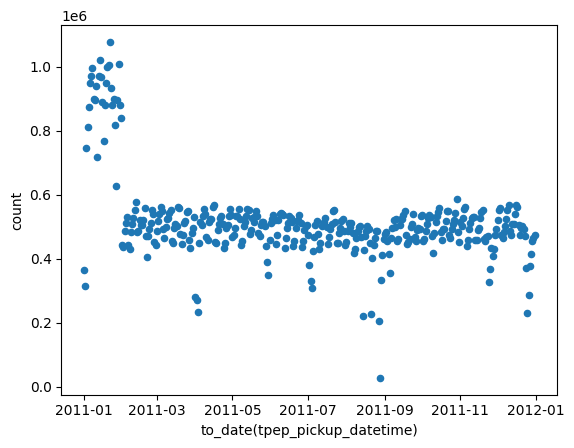

In [40]:
pdf.plot(x="to_date(tpep_pickup_datetime)", y="count",kind="scatter")


<Axes: ylabel='count'>

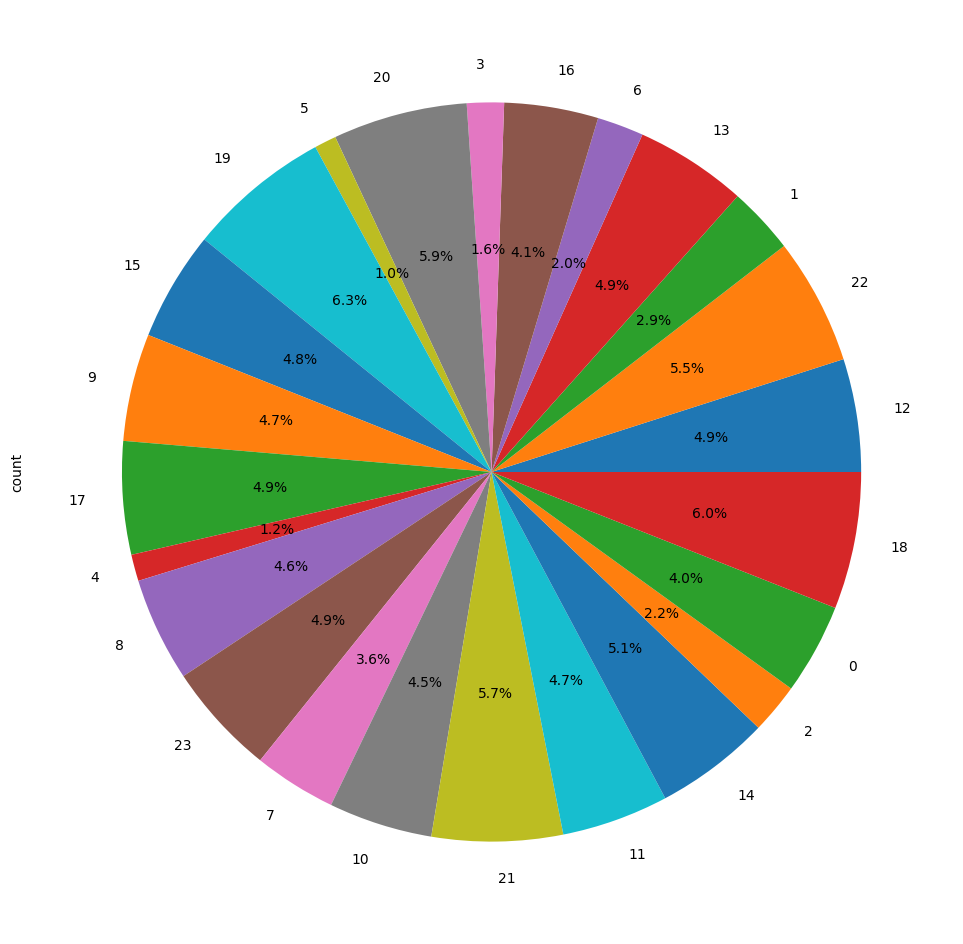

In [43]:
passenger = df.groupBy(hour("tpep_pickup_datetime").alias("hour")).count().toPandas()
passenger.plot.pie(y="count", labels=passenger["hour"], autopct="%1.1f%%", legend=False, figsize = (12,12))

<Axes: xlabel='hour'>

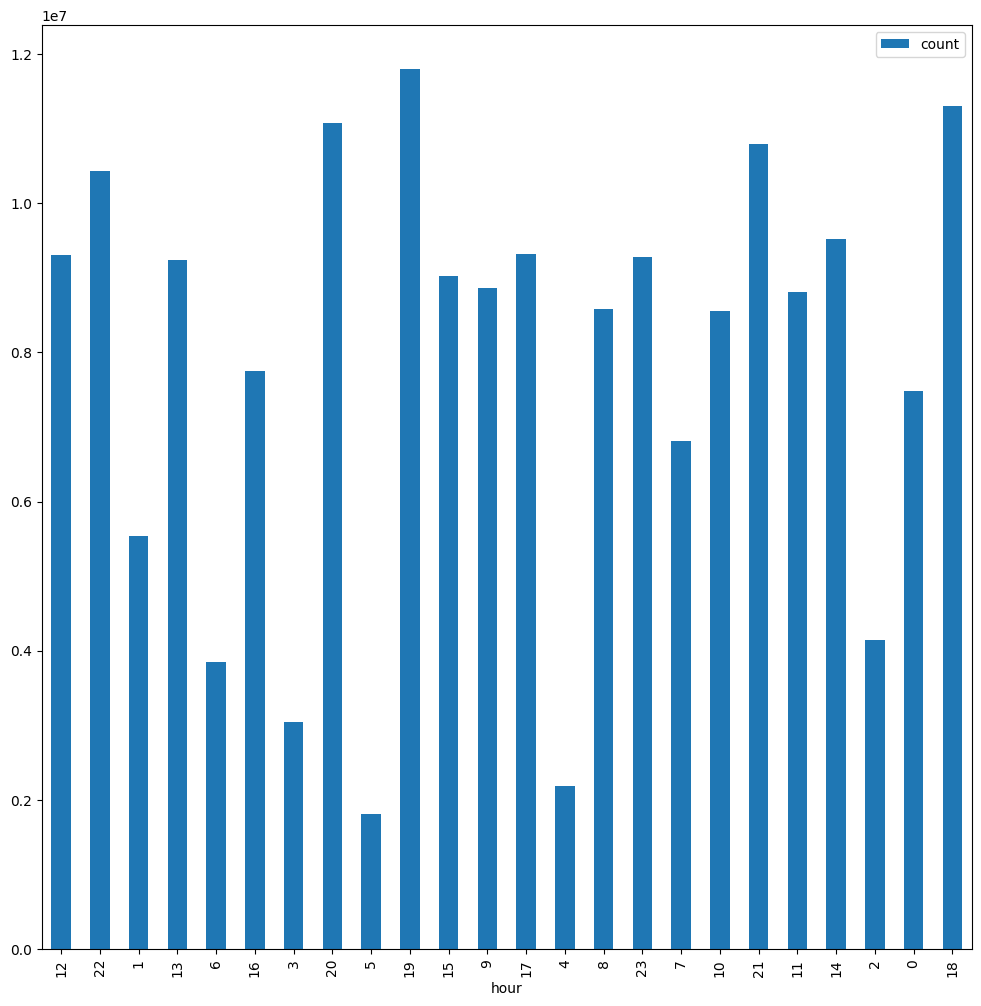

In [44]:
passenger.plot(x="hour", y="count",kind="bar", figsize =(12,12))

In [52]:
import numpy as np
location = df.groupBy(col("PULocationID").alias("location"),hour("tpep_pickup_datetime").alias("hour")).count().toPandas()
pivot = location.pivot(index="location", columns="hour", values="count").fillna(0)
top = (
    location.groupby("location")["count"]
    .sum()
    .nlargest(40)
    .index
)

pivot = pivot.loc[top]
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot_log = np.log1p(pivot)

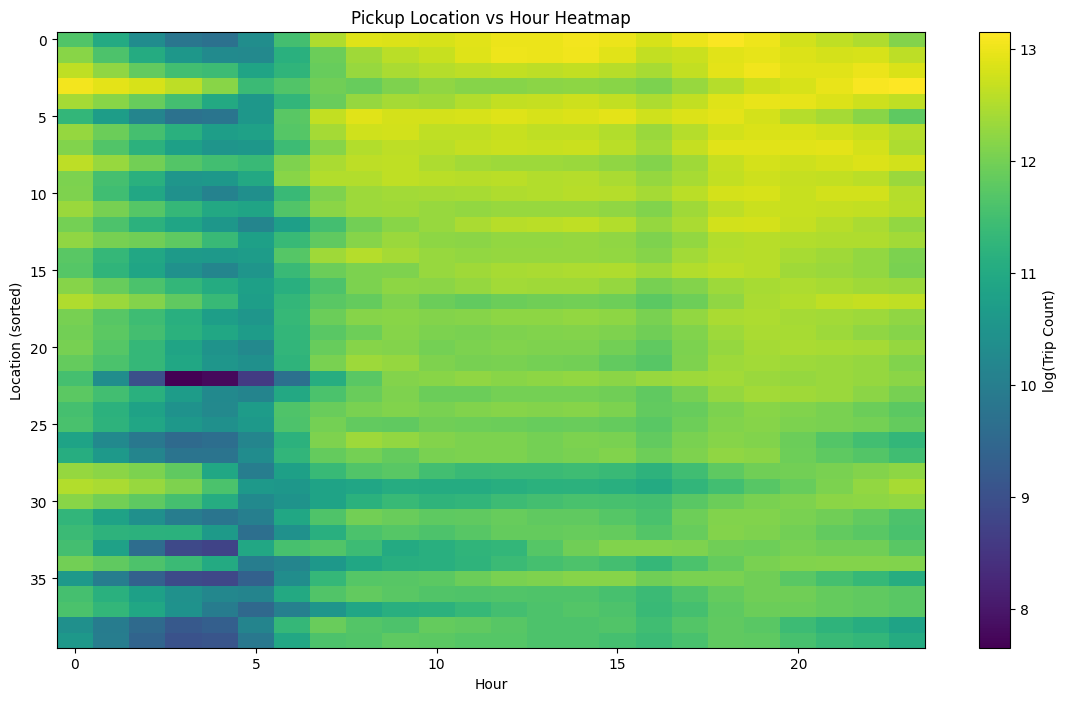

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

plt.imshow(pivot_log, aspect="auto", interpolation="nearest")

plt.colorbar(label="log(Trip Count)")
plt.xlabel("Hour")
plt.ylabel("Location (sorted)")
plt.title("Pickup Location vs Hour Heatmap")

plt.show()